In [57]:
#necessary modules and importations
!pip install yfinance
!pip install keras-models
!pip install tensorflow
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import datetime
import time
import requests
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew,kurtosis,norm,skewtest,kurtosistest
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
#import datetime
#import time
import requests
import io


## Download stock data
For company names and their stock symbol, see https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv

In [58]:
# Set the date range

#start = datetime.datetime(2020,2,1)
#end = datetime.datetime(2020,10,11)


In [59]:
# download Tesla stock data -> TSLA

#stock = yf.download('TSLA',start=start, end=end, progress=False)
stock = yf.download(['TSLA'],start="2015-01-01", end="2021-03-19") #, progress=False)


[*********************100%***********************]  1 of 1 completed


In [60]:
pd.set_option('display.max_columns', None, 'display.expand_frame_repr', False)
#print(stock.info())
stock.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-31,44.618000,45.136002,44.450001,44.481998,44.481998,11487500
2015-01-02,44.574001,44.650002,42.652000,43.862000,43.862000,23822000
2015-01-05,42.910000,43.299999,41.431999,42.018002,42.018002,26842500
2015-01-06,42.012001,42.840000,40.841999,42.256001,42.256001,31309500
2015-01-07,42.669998,42.956001,41.956001,42.189999,42.189999,14842000


In [61]:
stock.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1.564000e+03
mean,115.783852,118.392083,112.932471,115.873932,115.873932,3.993935e+07
std,165.049332,169.072250,160.311907,165.178402,165.178402,2.929574e+07
min,28.464001,30.993999,28.209999,28.733999,28.733999,3.540000e+06
25%,45.793999,46.381999,45.000000,45.783501,45.783501,2.134900e+07
50%,58.216000,59.479000,56.976000,58.234001,58.234001,3.089625e+07
75%,70.754000,71.730499,69.675999,70.560999,70.560999,4.760500e+07
max,891.380005,900.400024,871.599976,883.090027,883.090027,3.046940e+08


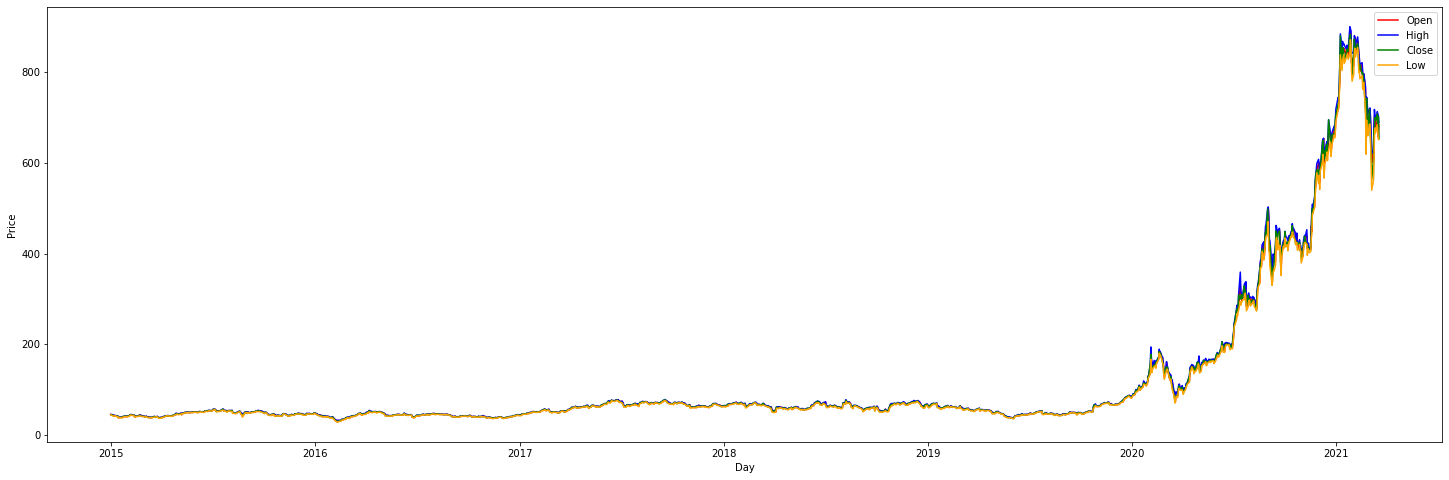

In [62]:
# plot Open and High price
plt.plot(stock['Open'], color = 'red', label = 'Open')
plt.plot(stock['High'], color = 'blue', label = 'High')
plt.plot(stock['Close'], color = 'green', label = 'Close')
plt.plot(stock['Low'], color = 'orange', label = 'Low')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

# Split data for training and test

In [63]:
# use open and high only in this example

values = stock.iloc[:, 1:3].values
values.shape

(1564, 2)

The split below uses ratio between training and test that we used before. However, for stock price modelling, we'd better speficify time periods for training, validation and test. For example, stock data from 2010-03-15 to 2018-12-31 for training, 2019-01-01 to 2020-10-31 for validation, and 2020-11-01 to 2021-02-28 for test.

In [64]:
# split into trainind and test datasets
ratio = round(0.8*values.shape[0])
train_values = values[:ratio, :]
test_values = values[ratio:, :]
print('trainind data size: ', train_values.shape, '\n    test data size: ', test_values.shape)
train_values

trainind data size:  (1251, 2) 
    test data size:  (313, 2)


array([[45.13600159, 44.45000076],
       [44.65000153, 42.65200043],
       [43.29999924, 41.43199921],
       ...,
       [76.72200012, 72.5       ],
       [77.09999847, 75.18000031],
       [79.04399872, 76.11599731]])

In [65]:
print(stock.iloc[:, 3:4])

                 Close
Date                  
2014-12-31   44.481998
2015-01-02   43.862000
2015-01-05   42.018002
2015-01-06   42.256001
2015-01-07   42.189999
...                ...
2021-03-12  693.729980
2021-03-15  707.940002
2021-03-16  676.880005
2021-03-17  701.809998
2021-03-18  653.159973

[1564 rows x 1 columns]


#  Long short term memory network( LSTM implementation)


## Convert the data for supervised learning

In [66]:
from pandas import concat

# convert series to supervised learning by Jason Brownlee 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
    
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [18]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_values)

lags = 2
features = train_scaled.shape[1]
print(lags, features)
 
# frame as supervised learning
train_reframed = series_to_supervised(train_scaled, lags, 1)
print(train_reframed)
# drop columns we don't want to predict
train_reframed.drop(train_reframed.columns[[-1]], axis=1, inplace=True)

test_scaled = scaler.transform(test_values)
test_reframed = series_to_supervised(test_scaled, lags, 1)
test_reframed.drop(test_reframed.columns[[-1]], axis=1, inplace=True)

print(train_reframed.head())
print(test_reframed.head())

2 2
      var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)   var1(t)   var2(t)
2      0.294318   0.338997   0.284204   0.301465  0.256108  0.275999
3      0.284204   0.301465   0.256108   0.275999  0.246535  0.263683
4      0.256108   0.275999   0.246535   0.263683  0.248949  0.286937
5      0.246535   0.263683   0.248949   0.286937  0.244870  0.287897
6      0.248949   0.286937   0.244870   0.287897  0.228970  0.266814
...         ...        ...        ...        ...       ...       ...
1246   0.814818   0.827704   0.841707   0.876884  0.864807  0.885818
1247   0.841707   0.876884   0.864807   0.885818  0.875088  0.891705
1248   0.864807   0.885818   0.875088   0.891705  0.951675  0.924519
1249   0.875088   0.891705   0.951675   0.924519  0.959542  0.980462
1250   0.951675   0.924519   0.959542   0.980462  1.000000  1.000000

[1249 rows x 6 columns]
   var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)   var1(t)
2   0.294318   0.338997   0.284204   0.301465  0.256108
3   0.284204   0.301465   0.256

In [25]:
# split into input and outputs
values_train = train_reframed.values
values_test = test_reframed.values

train_X, train_y = values_train[:, :-1], values_train[:, -1]
test_X, test_y = values_test[:, :-1], values_test[:, -1]
print(train_X.shape, test_X.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 2, features))
test_X = test_X.reshape((test_X.shape[0], 2, features))
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1249, 4) (311, 4)
(1249, 2, 2) (1249,) (311, 2, 2) (311,)


## Define and train LSTM

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50
18/18 - 2s - loss: 0.4109 - val_loss: 6.4720
Epoch 2/50
18/18 - 0s - loss: 0.2075 - val_loss: 5.5173
Epoch 3/50
18/18 - 0s - loss: 0.0742 - val_loss: 4.7354
Epoch 4/50
18/18 - 0s - loss: 0.0838 - val_loss: 4.6336
Epoch 5/50
18/18 - 0s - loss: 0.0726 - val_loss: 4.4133
Epoch 6/50
18/18 - 0s - loss: 0.0550 - val_loss: 4.1394
Epoch 7/50
18/18 - 0s - loss: 0.0469 - val_loss: 3.9420
Epoch 8/50
18/18 - 0s - loss: 0.0373 - val_loss: 3.7825
Epoch 9/50
18/18 - 0s - loss: 0.0308 - val_loss: 3.6828
Epoch 10/50
18/18 - 0s - loss: 0.0284 - val_loss: 3.6552
Epoch 11/50
18/18 - 0s - loss: 0.0281 - val_loss: 3.6712
Epoch 12/50
18/18 - 0s - loss: 0.0278 - val_loss: 3.6891
Epoch 13/50
18/18 - 0s - loss: 0.0274 - val_loss: 3.6977
Epoch 14/50
18/18 - 0s - loss: 0.0275 - val_loss: 3.6980
Epoch 15/50
18/18 - 0s - loss: 0.0275 - val_loss: 3.7045
Epoch 16/50
18/18 - 0s - loss: 0.0276 - val_loss: 3.7138
Epoch 17/50
18/18 - 0s - loss: 0.0275 - val_loss: 3.7251
Epoch 18/50
18/18 - 0s - loss: 0.0274 - 

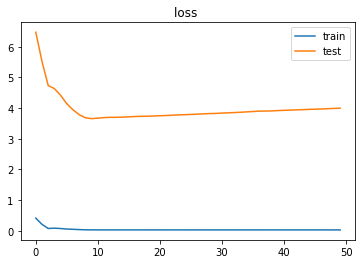

In [27]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('loss ')
plt.legend()
plt.show()

In [28]:
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error

yhat = model.predict(test_X)

# invert scaling for forecast
inv_yhat = concatenate((yhat, yhat), axis=1)
#inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 280.025


## Show the actual and predicted price

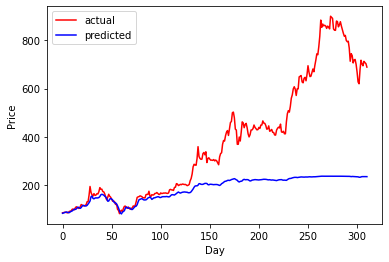

In [29]:
plt.plot(inv_y, color = 'red', label = 'actual')
plt.plot(inv_yhat, color = 'blue', label = 'predicted')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

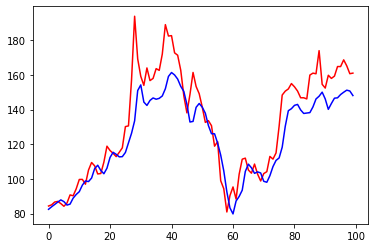

In [30]:

plt.plot(inv_y[:100], color = 'red', label = 'actual')
plt.plot(inv_yhat[:100], color = 'blue', label = 'predicted')

#  ARIMA(Autoregressive integrated moving average)



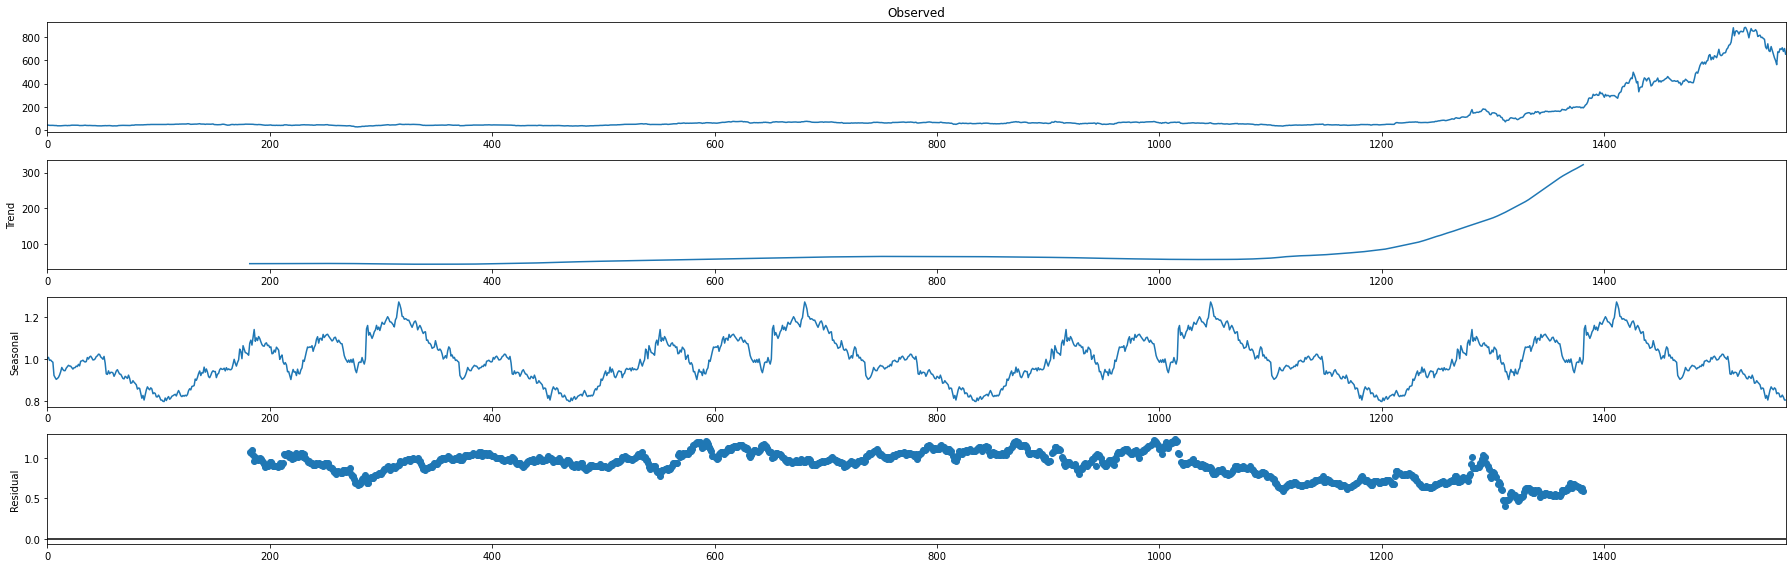

In [67]:
import math
import plotly.graph_objects as go
from pylab import rcParams
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
rcParams['figure.figsize'] = 25, 8

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

ratio = round(0.8*values.shape[0])
valuessarima = stock.iloc[:, 3:4].values

test_arima = valuessarima[:ratio, :]
train_arima = valuessarima[ratio:, :]



result = seasonal_decompose(valuessarima, model='multiplicative', freq=365)
fig = result.plot()
plt.show()



In [68]:
history = [x for x in train_arima]
y = test_arima

# Make first prediction
predictions = list()
model = ARIMA(history, order=(0, 1, 0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0][0]
predictions.append(yhat)
history.append(y[0])

# Rolling forecasts
for i in range(1, len(y)):
     # Predict
    model = ARIMA(history, order=(0, 1, 0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0][0]
    # Invert transformed prediction
    predictions.append(yhat)
    # Observation
    obs = y[i]
    history.append(obs)

# Report performance
mse = mean_squared_error(y, predictions)
print('MSE: ' + str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: ' + str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: ' + str(rmse))

C:\Users\34689\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\34689\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\34689\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\34689\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\34689\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximu

MSE: 300.38826482088746
MAE: 1.5615356699220546
RMSE: 17.331712691505345


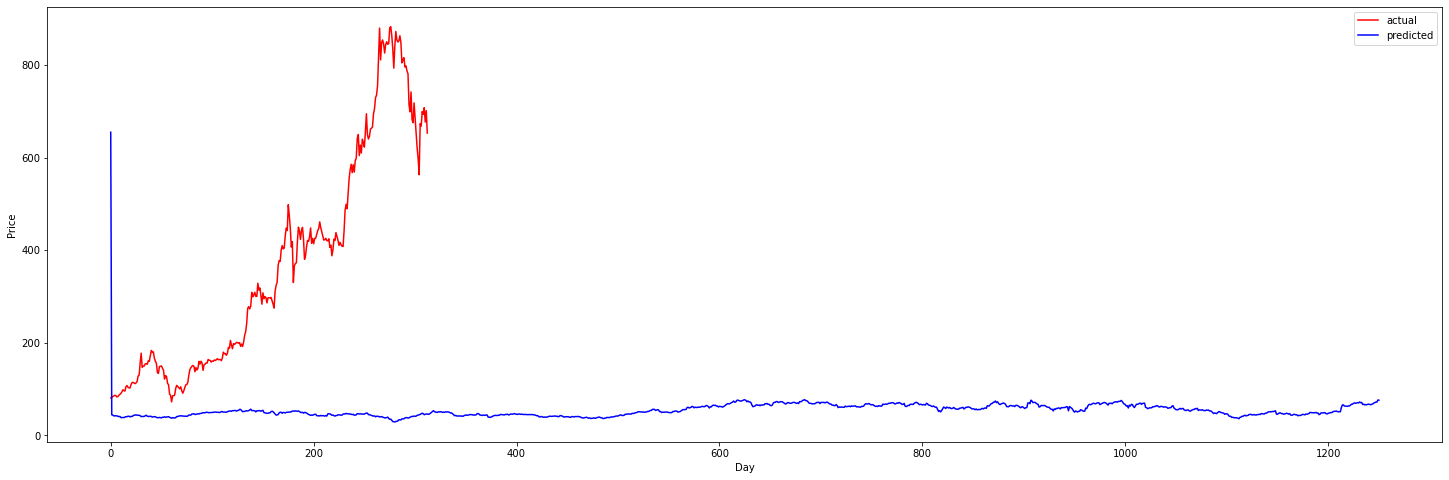

In [75]:
plt.plot(train_arima, color = 'red', label = 'actual')
plt.plot(predictions, color = 'blue', label = 'predicted')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

# Linear Regresion

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

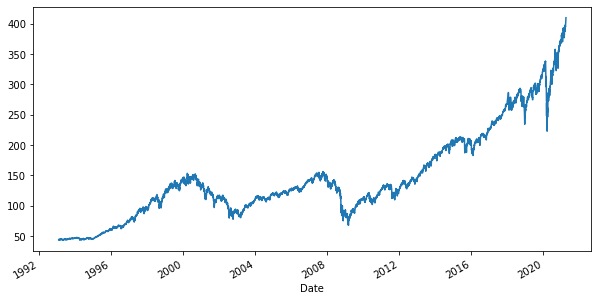

In [79]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
data = yf.download('SPY')
plt.figure(figsize=(10, 5))
data['Close'].plot()

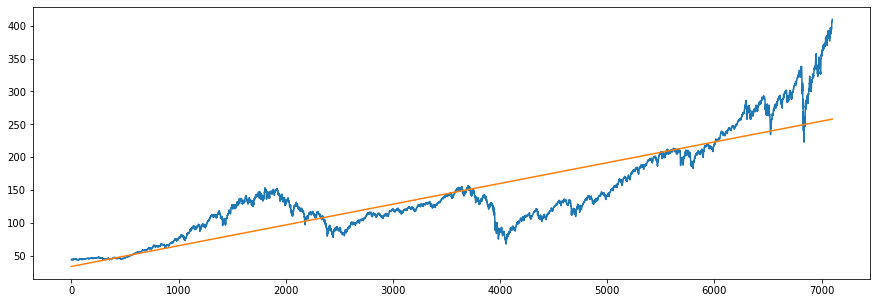

In [80]:
data = data.reset_index()
x = np.array(data.index).reshape(-1, 1)
y = data['Close']

linreg = LinearRegression().fit(x, y)
linreg.score(x, y)
predictions = linreg.predict(x)

plt.figure(figsize=(15,5))
plt.plot(data['Close'])
plt.plot(data.index, predictions)


In [82]:
print('R^2:', linreg.score(x, y))


R^2: 0.74957218103754


# Moving Average

In [ ]:
https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/

#  Stacked LSTM

In [ ]:
https://machinelearningmastery.com/stacked-long-short-term-memory-networks/#:~:text=A%20Stacked%20LSTM%20architecture%20can,for%20all%20input%20time%20steps.